## Business Understanding
Objective: Predict the unit sales for thousands of items sold at different Favorita stores.

Business Goals:

1. Ensure optimal stock levels at all stores.

2. Improve demand forecasting accuracy.

3. Understand factors affecting sales (promotions, holidays, oil prices, etc.).

Analytical Questions:

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

## Data Understanding

Importing Libraries

In [1]:
import pyodbc     
from dotenv import dotenv_values    #import the dotenv_values function from the dotenv package
from dotenv import load_dotenv
import pandas as pd
import warnings 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from plotly.subplots import make_subplots
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer


warnings.filterwarnings('ignore')

Connecting to the database

In [2]:
# Load environment variables from .env file
load_dotenv()
environment_variables=dotenv_values('.env')# Get the values for the credentials you set in the '.env' file
database=environment_variables.get("DATABASE")
server=environment_variables.get("SERVER")
username=environment_variables.get("USERNAME")
password=environment_variables.get("PASSWORD")

# Specify port if necessary (default SQL Server port is 1433)
port = 1433
server_with_port = f"{server},{port}"

# Update connection string to use ODBC Driver 17 for SQL Server
connection_string = (
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER={dap-projects-database.database.windows.net};"
    "DATABASE={dapDB};"
    "UID={learning_project_3};"
    "PWD={A$uB1Lp3$2@24}"
)

 
try:
    # Establish connection to the database
    conn = pyodbc.connect(connection_string)
    cursor = conn.cursor()

    # Example query to test the connection
    cursor.execute("SELECT TOP 10 * FROM dbo.oil")
    rows = cursor.fetchall()

    for row in rows:
        print(row)

except pyodbc.Error as ex:
    print("OperationalError:")
    print("Arguments:", ex.args)
    print("Connection String:", connection_string)

(datetime.date(2013, 1, 1), None)
(datetime.date(2013, 1, 2), 93.13999938964844)
(datetime.date(2013, 1, 3), 92.97000122070312)
(datetime.date(2013, 1, 4), 93.12000274658203)
(datetime.date(2013, 1, 7), 93.19999694824219)
(datetime.date(2013, 1, 8), 93.20999908447266)
(datetime.date(2013, 1, 9), 93.08000183105469)
(datetime.date(2013, 1, 10), 93.80999755859375)
(datetime.date(2013, 1, 11), 93.5999984741211)
(datetime.date(2013, 1, 14), 94.2699966430664)


In [3]:
#reading the oil table
query = "SELECT * FROM dbo.oil"

oil = pd.read_sql(query, conn)
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [4]:
#reading the holidays_events table
query = "SELECT * FROM dbo.holidays_events"

holidays_events = pd.read_sql(query, conn)
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
#reading the stores table
query = "SELECT * FROM dbo.stores"

stores = pd.read_sql(query, conn)
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
# Loading other datasets
train_data = pd.read_csv(r'C:\Users\magyir\Downloads\store-sales-forecasting\train.csv', parse_dates=['date'])
transactions = pd.read_csv(r"C:\Users\magyir\Downloads\store-sales-forecasting\transactions.csv", parse_dates=['date'])
sample_submission = pd.read_csv(r"C:\Users\magyir\Downloads\sample_submission.csv")
test = pd.read_csv(r"C:\Users\magyir\Downloads\test.csv", parse_dates=['date'])

In [7]:
# Ensuring date columns are in datetime format
train_data['date'] = pd.to_datetime(train_data['date'])
test['date'] = pd.to_datetime(test['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

# Merging the train datasets
train_data = train_data.merge(stores, on='store_nbr', how='left')
train_data = train_data.merge(oil, on='date', how='left')
train_data = train_data.merge(transactions, on=['date', 'store_nbr'], how='left')
train_data = train_data.merge(holidays_events, on='date', how='left')



In [8]:
#merge the test dataset


In [9]:
#view first 5 rows for merged data
train_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,transactions,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [10]:
#view first 5 rows for merged data
train_data.tail()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,transactions,type_y,locale,locale_name,description,transferred
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054347,3000887,2017-08-15,9,SEAFOOD,16.000,0,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   type_x        object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  transactions  float64       
 12  type_y        object        
 13  locale        object        
 14  locale_name   object        
 15  description   object        
 16  transferred   object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(9)
memory usage: 396.1+ MB


Data Cleaning

In [12]:
# Identify missing values
missing_values = train_data.isnull().sum()
print("Missing values before cleaning:")
print(missing_values[missing_values > 0])



Missing values before cleaning:
dcoilwtico       955152
transactions     249117
type_y          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64


In [13]:
# Handle missing values

# Identify numerical and categorical columns
numerical_cols = train_data.select_dtypes(include=[np.number]).columns
categorical_cols = train_data.select_dtypes(include=[object]).columns

# For numerical, we will use interpolation to fill missing values
train_data[numerical_cols] = train_data[numerical_cols].interpolate(method='linear')

# For categorical, replace missing values with a new category,'Unknown' 
constant_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
train_data[categorical_cols] = constant_imputer.fit_transform(train_data[categorical_cols])



In [14]:
# Identify missing values after cleaning
missing_values = train_data.isnull().sum()
print("Missing values after cleaning:")
print(missing_values[missing_values > 0])


Missing values after cleaning:
dcoilwtico      1782
transactions     561
dtype: int64


In [15]:
# Handling the rest of the missing values using Mean imputation.
mean_imputer = SimpleImputer(strategy='mean')
train_data[numerical_cols] = mean_imputer.fit_transform(train_data[numerical_cols])

In [16]:
# Identify missing values after cleaning
missing_values = train_data.isnull().sum()
print("Missing values after cleaning:")
print(missing_values[missing_values > 0])

Missing values after cleaning:
Series([], dtype: int64)


## EDA

In [17]:
# Summary Statistics
print("Summary Statistics:")
train_data.describe()



Summary Statistics:


,id,date,store_nbr,sales,onpromotion,cluster,dcoilwtico,transactions
count,3.054348e+06,3054348,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06
mean,1.504277e+06,2015-04-26 12:11:45.717619200,2.750000e+01,3.590209e+02,2.617480e+00,8.481481e+00,6.780983e+01,1.677344e+03
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01,5.000000e+00
25%,7.546768e+05,2014-03-01 00:00:00,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.632000e+01,1.059000e+03
50%,1.507572e+06,2015-04-28 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00,5.329665e+01,1.392000e+03
75%,2.255120e+06,2016-06-22 00:00:00,4.100000e+01,1.960110e+02,0.000000e+00,1.300000e+01,9.576844e+01,2.017000e+03
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02,8.359000e+03
std,8.662610e+05,NaN,1.558579e+01,1.107286e+03,1.225494e+01,4.649735e+00,2.567412e+01,9.389467e+02


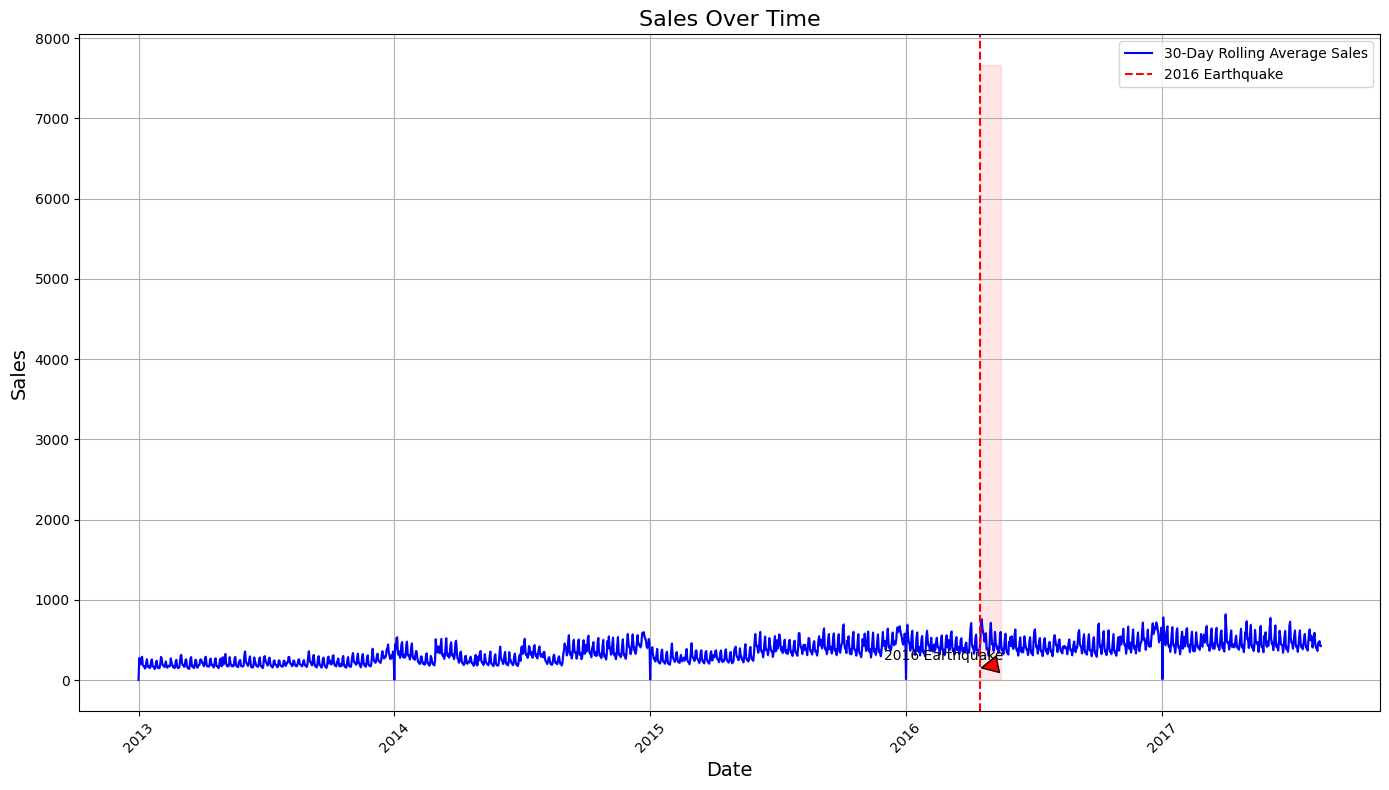

In [18]:
#Time Series Analysis (Sales Over Time)

train_data['sales_rolling'] = train_data['sales'].rolling(window=30).mean()

plt.figure(figsize=(14, 8))
sns.lineplot(x='date', y='sales_rolling', data=train_data, color='blue', label='30-Day Rolling Average Sales', linewidth=1.5)
plt.title('Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)

# Highlight the earthquake period
plt.axvline(pd.to_datetime('2016-04-16'), color='red', linestyle='--', label='2016 Earthquake')
plt.fill_betweenx(y=[0, max(train_data['sales_rolling'].dropna())], x1=pd.to_datetime('2016-04-16'), x2=pd.to_datetime('2016-05-16'), color='red', alpha=0.1)

# Annotations for specific events
plt.annotate('2016 Earthquake', xy=(pd.to_datetime('2016-04-16'), 150), xytext=(pd.to_datetime('2015-12-01'), 250),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




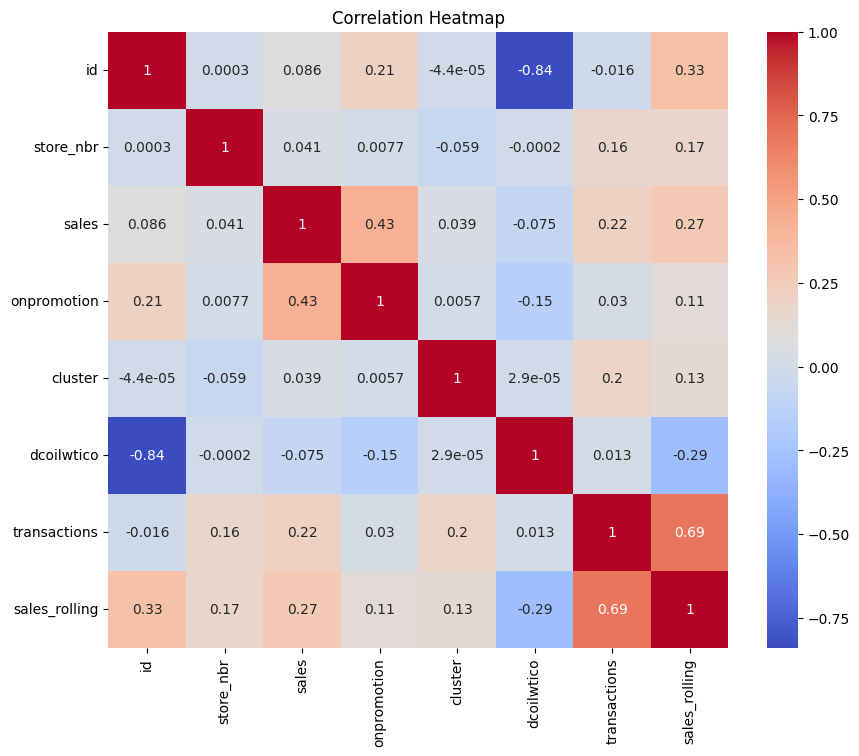

In [19]:
# Correlation Analysis

numeric_cols = train_data.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_cols.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



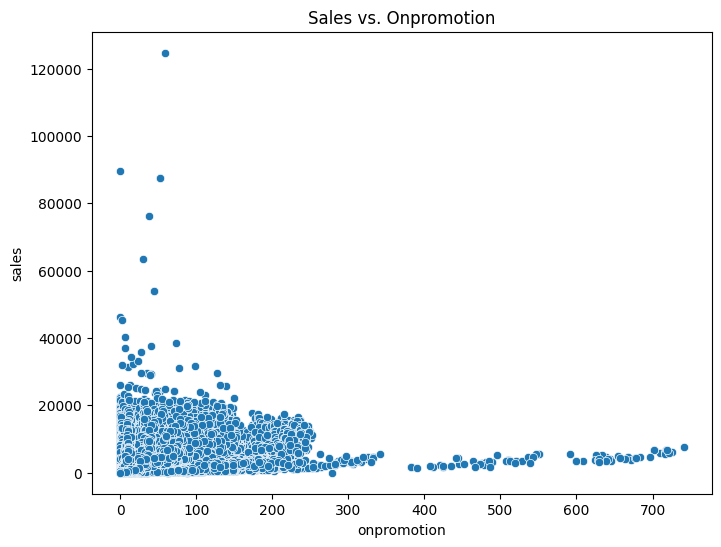

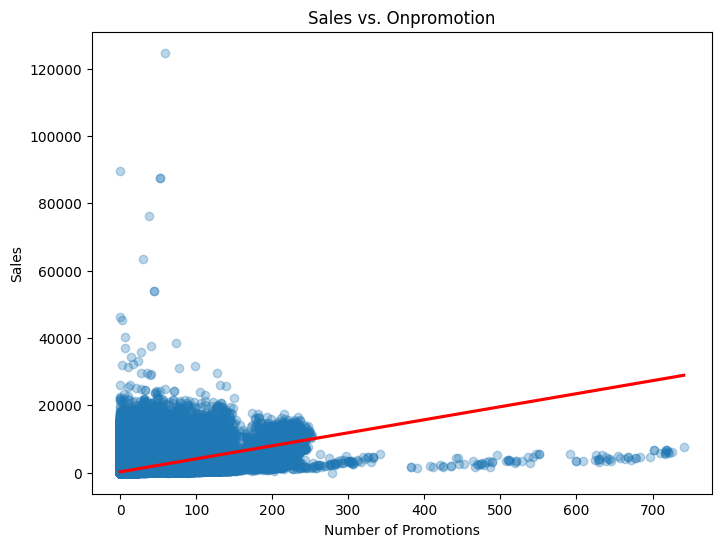

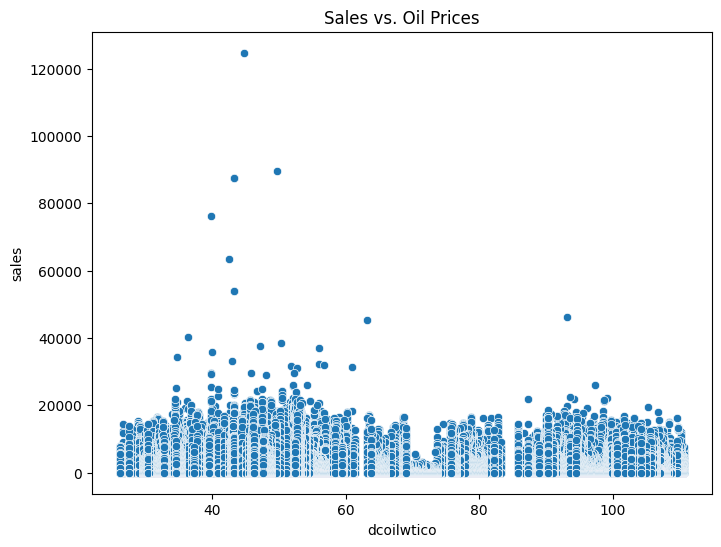

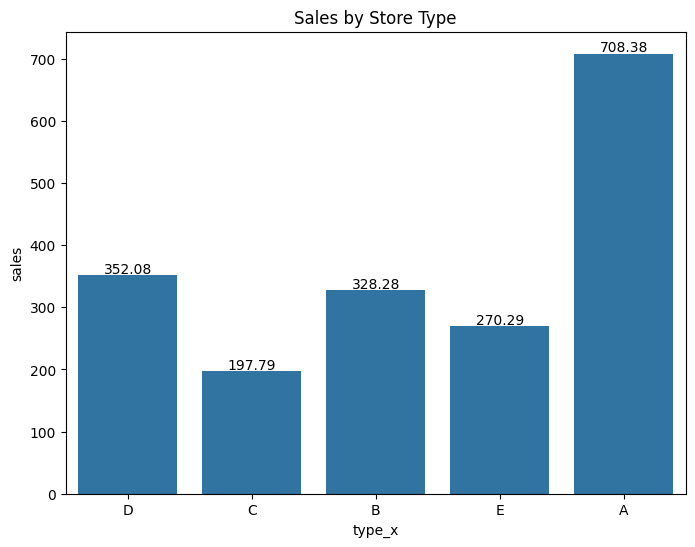

In [20]:
# Scatter Plot
# Sales vs. Promotions
plt.figure(figsize=(8, 6))
sns.scatterplot(x='onpromotion', y='sales', data=train_data)
plt.title('Sales vs. Onpromotion')
plt.show()

plt.figure(figsize=(8, 6))
sns.regplot(x='onpromotion', y='sales', data=train_data, scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
plt.title('Sales vs. Onpromotion')
plt.xlabel('Number of Promotions')
plt.ylabel('Sales')
plt.show()


# Sales vs. Oil Prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x='dcoilwtico', y='sales', data=train_data)
plt.title('Sales vs. Oil Prices')
plt.show()

# Sales by Store Type
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='type_x', y='sales', data=train_data, ci=None)
plt.title('Sales by Store Type')

# Add data labels
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width() / 2,
            y=height + 3,
            s=f'{height:.2f}',
            ha='center')

plt.show()




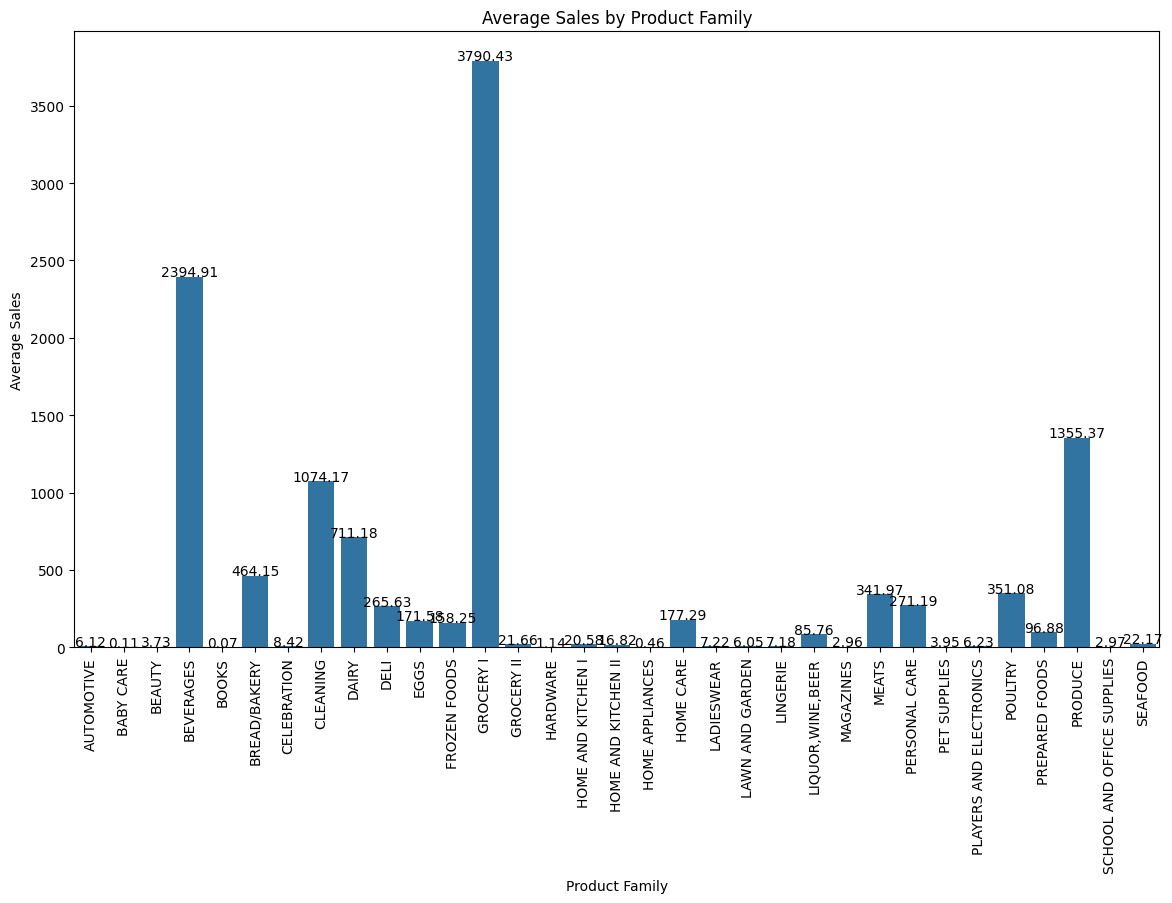

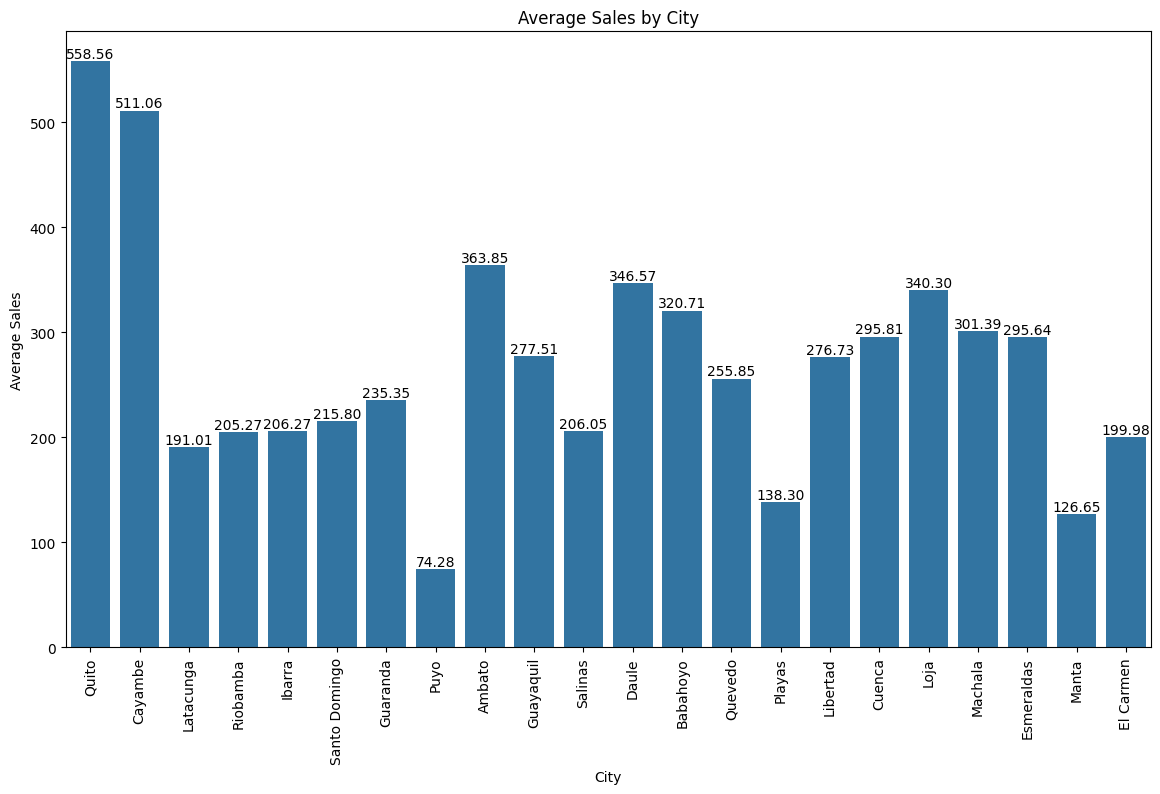

In [21]:
# Sales by product family
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='family', y='sales', data=train_data, estimator=np.mean, ci=None)
plt.title('Average Sales by Product Family')
plt.xticks(rotation=90)
plt.xlabel('Product Family')
plt.ylabel('Average Sales')

# Add data labels
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width() / 2,
            y=height + 3,
            s=f'{height:.2f}',
            ha='center')

plt.show()

# Sales by city
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='city', y='sales', data=train_data, estimator=np.mean, ci=None)
plt.title('Average Sales by City')
plt.xticks(rotation=90)
plt.xlabel('City')
plt.ylabel('Average Sales')

# Add data labels
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width() / 2,
            y=height + 3,
            s=f'{height:.2f}',
            ha='center')

plt.show()


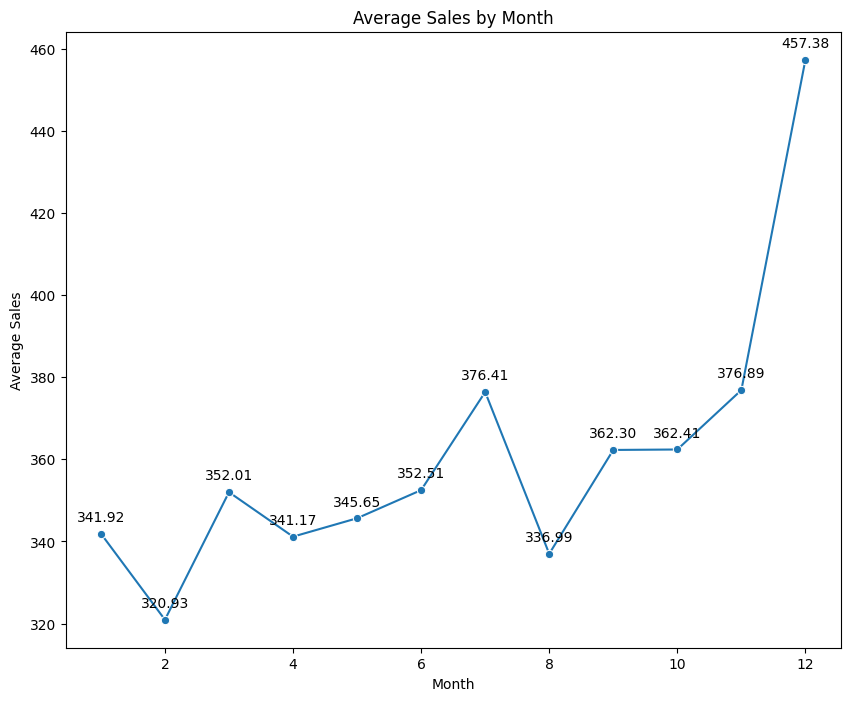

In [22]:
# Sales by Month
train_data['month'] = train_data['date'].dt.month

plt.figure(figsize=(10, 8))
ax = sns.lineplot(x='month', y='sales', data=train_data, estimator=np.mean, ci=None, marker='o')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')

# Add data labels
for x, y in zip(range(1, 13), train_data.groupby('month')['sales'].mean()):
    plt.text(x=x, y=y + 3, s=f'{y:.2f}', ha='center')

plt.show()


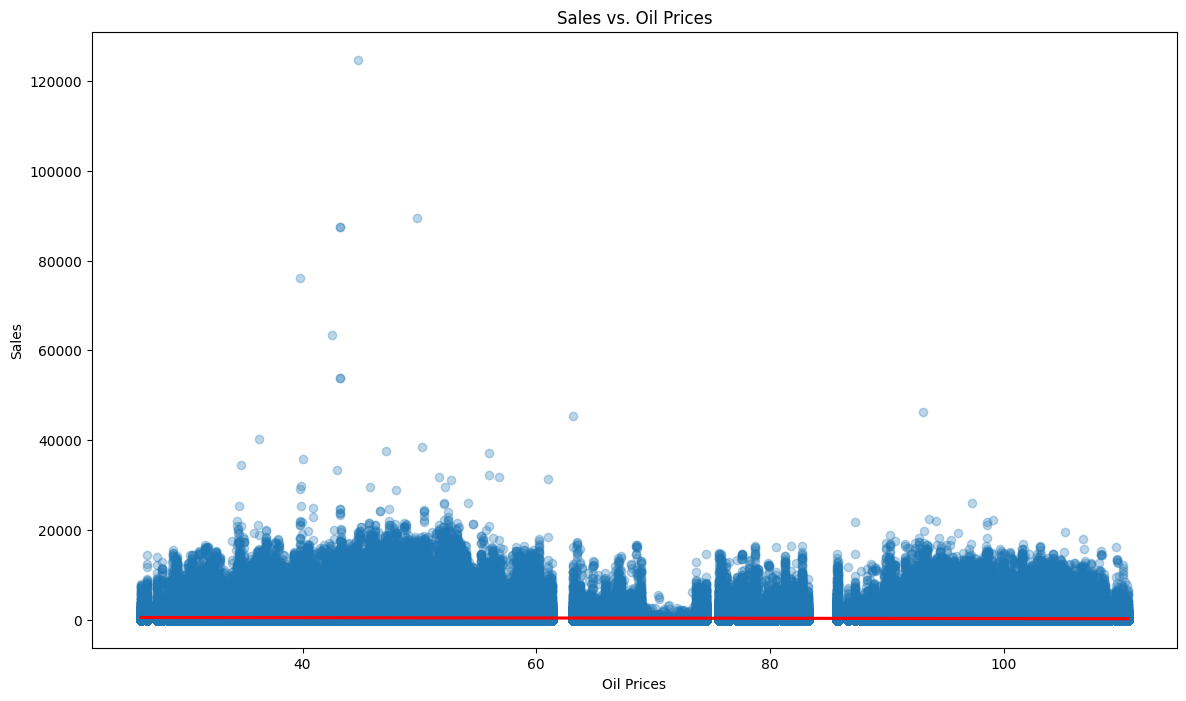

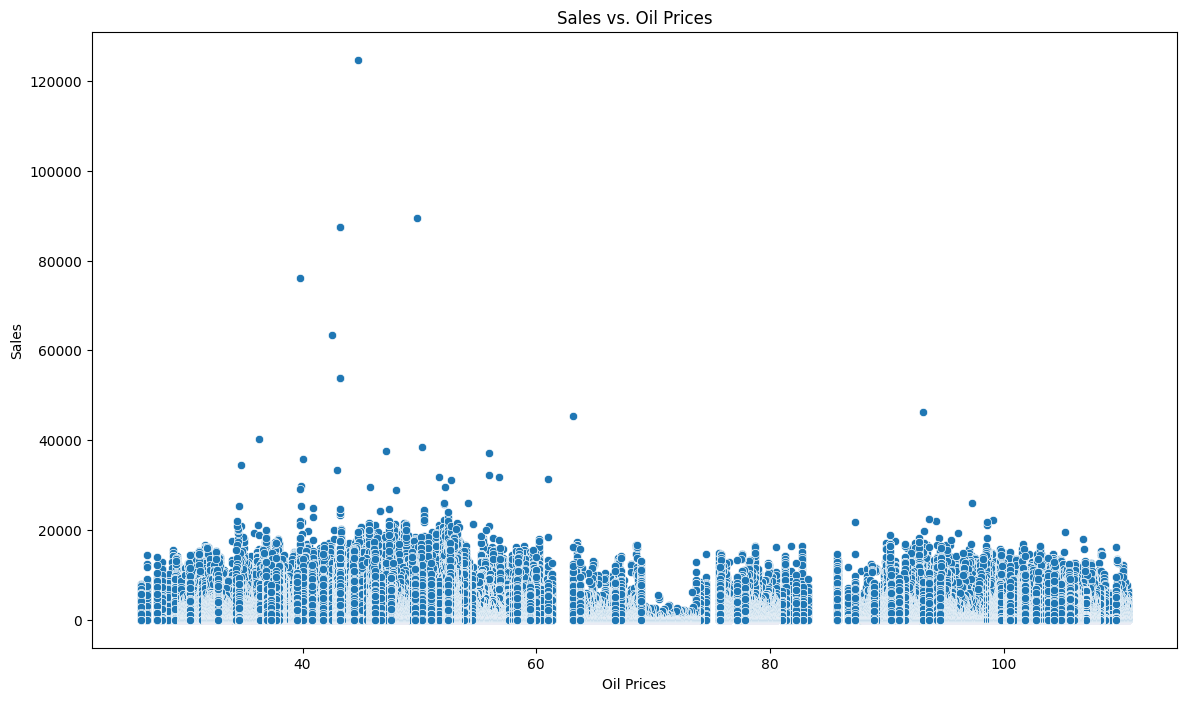

In [24]:
#Impact of oil prices
plt.figure(figsize=(14, 8))
sns.regplot(x='dcoilwtico', y='sales', data=train_data, scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
plt.title('Sales vs. Oil Prices')
plt.xlabel('Oil Prices')
plt.ylabel('Sales')
plt.show()

plt.figure(figsize=(14, 8))
sns.scatterplot(x='dcoilwtico', y='sales', data=train_data)
plt.title('Sales vs. Oil Prices')
plt.xlabel('Oil Prices')
plt.ylabel('Sales')
plt.show()
